<a href="https://colab.research.google.com/github/LauraJDiaz/Ciencia-De-Datos/blob/main/AnalisisVero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsmodels
!pip install wquantiles

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import stats
from statsmodels import robust
import seaborn as sns
import wquantiles
import matplotlib.pyplot as plt
import os
from math import pi
from scipy.stats import f
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Verodatos.xlsx'
df = pd.read_excel(file_path)



Mounted at /content/drive


#Limpieza de datos#

In [ ]:
# Convertir 'win' de True/False a 1/0
df['win'] = df['win'].astype(int)


# Separar los items en columnas item_1 a item_7
items_df = df['items'].apply(pd.Series)
items_df.columns = [f'item_{i+1}' for i in range(items_df.shape[1])]
df = pd.concat([df.drop(columns=['items']), items_df], axis=1)

#Convertir columnas numéricas a enteros si es posible
for col in df.columns:
    if df[col].dtype == float and df[col].dropna().apply(float.is_integer).all():
        df[col] = df[col].astype('Int64')  # Soporta valores nulos

# Eliminar columnas que no aportan al análisis
columnas_inutiles = ['puuid', 'summoner_id', 'summoner_name', 'match_id', 'teams']
df = df.drop(columns=columnas_inutiles, errors='ignore')


#Agregar Codigo al campeon
le = LabelEncoder()

# Transformar la columna 'champion'
df['champion_code'] = le.fit_transform(df['champion'])

# Mostrar ejemplo
df[['champion', 'champion_code']].drop_duplicates().sort_values('champion_code').head()

,champion,champion_code
52,Amumu,0
95,Brand,1
18,Darius,2
7,DrMundo,3
5,FiddleSticks,4


#  Descripción de variables del dataset de League of Legends

## Información general del juego
- `date`: Fecha de la partida (formato timestamp).
- `region`: Región del servidor (ej. LAN, NA, EUW).
- `game_id`: Identificador único del juego.
- `game_name`: Nombre de la partida.
- `game_type`: Tipo de juego (ej. MATCHED_GAME).
- `game_version`: Versión del juego usada en la partida.
- `game_creation`: Timestamp de creación de la partida.
- `game_duration`: Duración total de la partida (en segundos).
- `platform_id`: Plataforma del servidor (ej. LA1).
- `map_id`: ID del mapa usado (generalmente 11 = Grieta del Invocador).
- `queue_id`: Código de la cola (ej. 420 = SoloQ Ranked).

## Información del jugador
- `champion`: Campeón jugado por el jugador.
- `win`: Resultado de la partida (1 = victoria, 0 = derrota).
- `team_position`: Posición jugada (ej. TOP, JUNGLE, MIDDLE).
- `lane`: Línea principal (TOP, MID, JUNGLE, BOT).
- `role`: Rol asignado en el equipo (SOLO, DUO, CARRY, SUPPORT).
- `level`: Nivel alcanzado al final de la partida.
- `summoner_spells`: Lista de IDs de los hechizos de invocador usados.
- `participants`: Información de los participantes del juego (puede incluir los 10 jugadores).

## Rendimiento del jugador
- `kills`: Asesinatos hechos por el jugador.
- `deaths`: Veces que el jugador murió.
- `assists`: Asistencias a asesinatos.
- `kda`: Ratio KDA = (Kills + Assists) / Deaths.
- `cs`: Cantidad de súbditos asesinados (Creep Score).
- `gold_earned`: Oro ganado.
- `gold_spent`: Oro gastado.
- `vision_score`: Puntaje de visión (control del mapa).
- `vision_wards_bought_in_game`: Centinelas de visión comprados.
- `wards_placed`: Centinelas colocados.
- `wards_destroyed`: Centinelas enemigos destruidos.
- `total_minions_killed`: Total de súbditos eliminados.

## Daño e impacto en combate
- `total_damage_dealt`: Daño total hecho.
- `damage_to_champs`: Daño hecho a campeones enemigos.
- `damage_taken`: Daño total recibido.
- `total_damage_taken`: Igual que `damage_taken`.
- `magic_damage_dealt`: Daño mágico infligido.
- `physical_damage_dealt`: Daño físico infligido.
- `true_damage_dealt`: Daño verdadero infligido.
- `timeCCingOthers`: Tiempo total de control de masas sobre enemigos (en segundos).
- `total_units_healed`: Cantidad total de unidades curadas.

## Jugadas destacadas
- `largest_killing_spree`: Mayor racha de asesinatos sin morir.
- `largest_multi_kill`: Mayor número de kills seguidas (doble, triple...).
- `killing_sprees`: Número de rachas de asesinatos logradas.
- `longest_time_spent_living`: Mayor tiempo vivo sin morir.
- `totalTimeSpentDead`: Tiempo total muerto durante la partida (en segundos).

## Objetivos del equipo
- `dragons_killed`: Número de dragones matados por el equipo del jugador.
- `barons_killed`: Barones matados por el equipo del jugador.
- `turret_kills`: Torres destruidas por el jugador.

## Ítems y configuraciones
- `item_1 al item_7`: Items comprados por eljugador.
- `perks`: Conjunto de runas o perks seleccionadas (en formato de lista o string).


#Analisis Exploratorio

In [ ]:
df_ranked = df[df['queue_id'].isin([420,440])].copy()

print(f"Total de partidas ranked: {df_ranked.shape[0]}")


Total de partidas ranked: 91


<ipython-input-9-cfaa7e6252f9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=conteo.index, y=conteo.values, palette=colors)


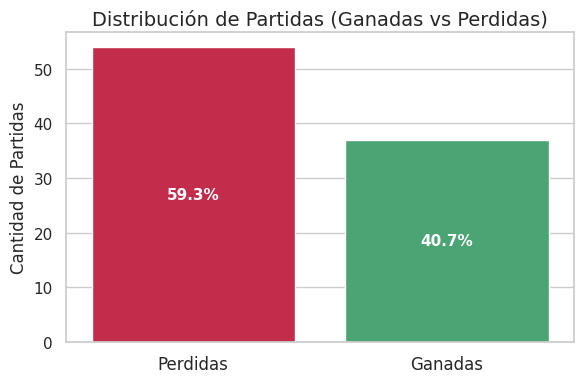

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))

conteo = df_ranked['win'].value_counts().sort_index()
porcentaje = conteo / conteo.sum() * 100

#
colors = ['#DC143C', '#3CB371']  # Rojo para derrotas, verde agua para victorias
bars = sns.barplot(x=conteo.index, y=conteo.values, palette=colors)

# Etiquetas
plt.title("Distribución de Partidas (Ganadas vs Perdidas)", fontsize=14)
plt.xticks([0, 1], ['Perdidas', 'Ganadas'], fontsize=12)
plt.ylabel("Cantidad de Partidas", fontsize=12)
plt.xlabel("")
for i, (val, pct) in enumerate(zip(conteo.values, porcentaje)):
    bars.text(i, val / 2, f"{pct:.1f}%", ha='center', va='center', fontsize=11, fontweight='bold', color='white')

plt.tight_layout()
plt.show()



<ipython-input-10-9445e49e3816>:18: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f_val, p_val = stats.f_oneway(group1, group0)


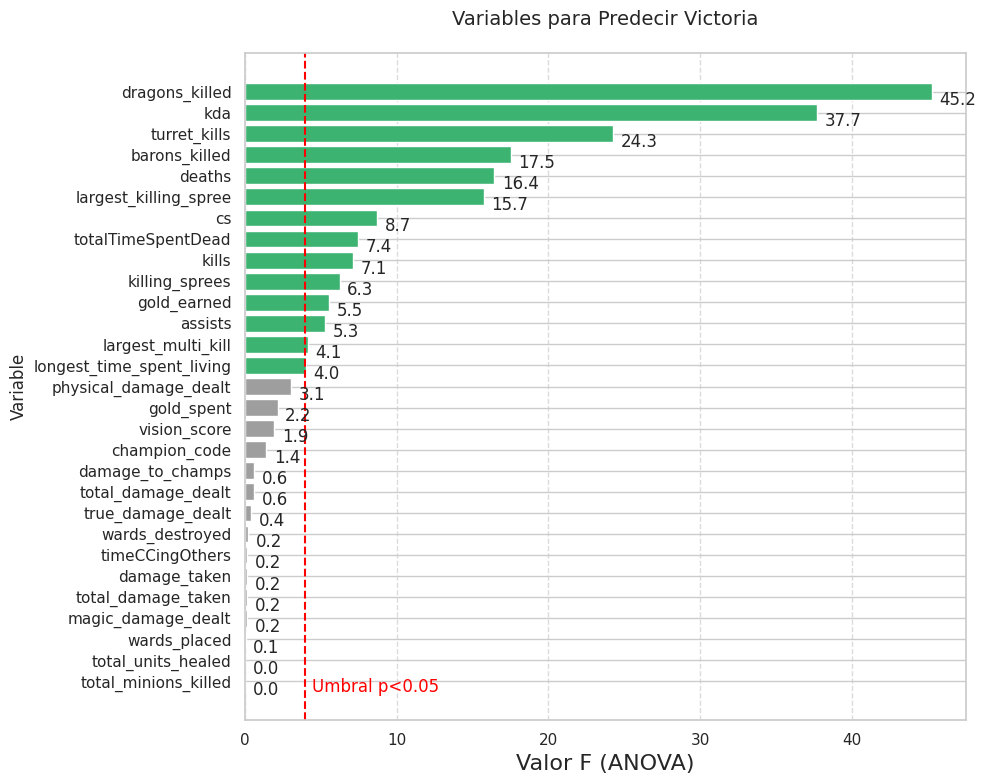

In [ ]:
f_values = []
p_values = []
variables = ['champion_code', 'kills', 'deaths',
       'assists', 'kda', 'cs', 'vision_score', 'gold_earned', 'gold_spent',
       'total_damage_dealt', 'total_damage_taken', 'magic_damage_dealt',
       'physical_damage_dealt', 'true_damage_dealt', 'timeCCingOthers',
       'total_minions_killed', 'largest_killing_spree', 'largest_multi_kill',
       'killing_sprees', 'longest_time_spent_living',
       'total_units_healed', 'totalTimeSpentDead','damage_to_champs', 'damage_taken',
       'dragons_killed', 'barons_killed', 'turret_kills', 'wards_placed',
       'wards_destroyed']


#Anova
for var in variables:
    group1 = df_ranked[df_ranked['win'] == 1][var]
    group0 = df_ranked[df_ranked['win'] == 0][var]
    f_val, p_val = stats.f_oneway(group1, group0)
    f_values.append(f_val)
    p_values.append(p_val)

anova_results = pd.DataFrame({
    'Variable': variables,
    'F_value': f_values,
    'p_value': p_values
}).sort_values('F_value', ascending=False)


# Gráfico
plt.figure(figsize=(10, 8))
bars = plt.barh(anova_results['Variable'], anova_results['F_value'],
                color=['#3CB371' if p < 0.05 else '#9E9E9E' for p in anova_results['p_value']])

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height(),
             f'{width:.1f}', ha='left', va='center')

# Línea
max_f = max(f_values) * 1.1
plt.axvline(x=f.ppf(0.95, 1, len(df_ranked)-2), color='red', linestyle='--')
plt.text(f.ppf(0.95, 1, len(df_ranked)-2)+0.5, len(variables)-0.5,
         'Umbral p<0.05', color='red')

plt.xlabel('Valor F (ANOVA)', fontsize=16)
plt.ylabel('Variable', fontsize=12)
plt.title('Variables para Predecir Victoria',
          fontsize=14, pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
anova_variables = [
    'dragons_killed', 'kda', 'turret_kills', 'barons_killed', 'deaths',
    'largest_killing_spree', 'cs', 'totalTimeSpentDead', 'kills', 'killing_sprees'
]


<ipython-input-12-decfc35151de>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ranked, x='win', y=var, ax=axes[i], palette=['#F44336','#4CAF50', ])
<ipython-input-12-decfc35151de>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Perdidas', 'Ganadas'])
<ipython-input-12-decfc35151de>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ranked, x='win', y=var, ax=axes[i], palette=['#F44336','#4CAF50', ])
<ipython-input-12-decfc35151de>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axe

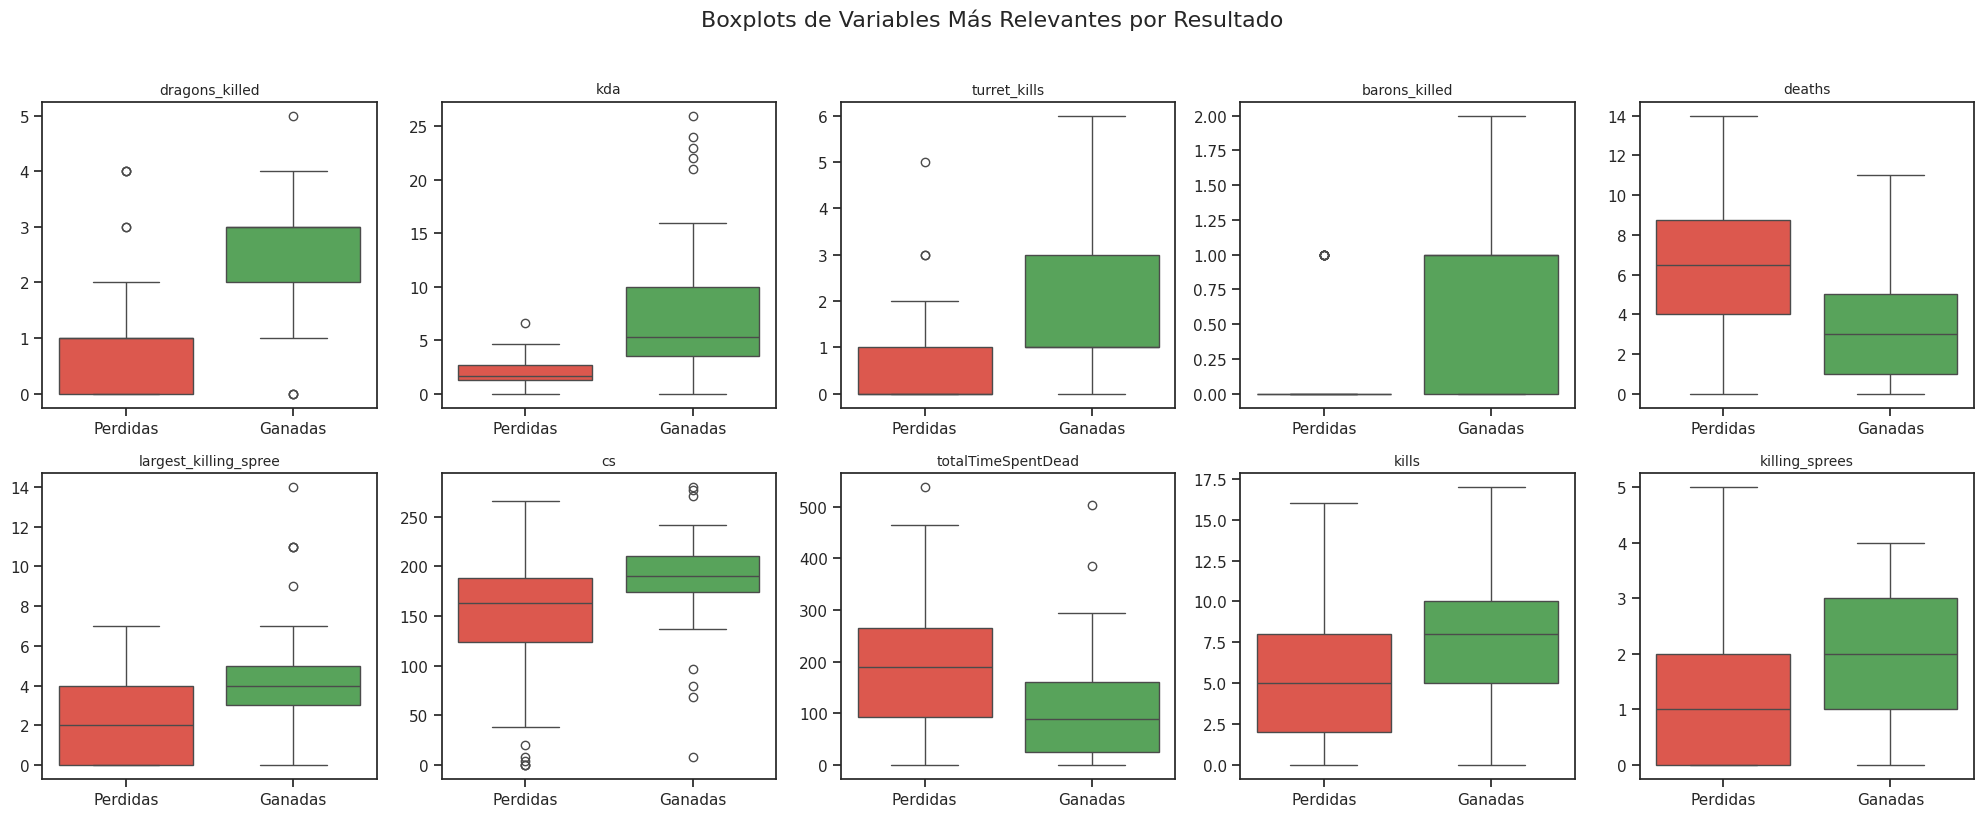

In [ ]:
sns.set(style="ticks", palette="Set2")

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()  # Convertir en lista

for i, var in enumerate(anova_variables):
    sns.boxplot(data=df_ranked, x='win', y=var, ax=axes[i], palette=['#F44336','#4CAF50', ])
    axes[i].set_title(f'{var}', fontsize=10)
    axes[i].set_xticklabels(['Perdidas', 'Ganadas'])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Eliminar ejes vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar espacio
plt.suptitle("Boxplots de Variables Más Relevantes por Resultado", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
df.columns

Index(['date', 'region', 'game_id', 'champion', 'win', 'kills', 'deaths',
       'assists', 'kda', 'cs', 'vision_score', 'gold_earned', 'gold_spent',
       'total_damage_dealt', 'total_damage_taken', 'magic_damage_dealt',
       'physical_damage_dealt', 'true_damage_dealt', 'timeCCingOthers',
       'total_minions_killed', 'largest_killing_spree', 'largest_multi_kill',
       'killing_sprees', 'perks', 'longest_time_spent_living',
       'total_units_healed', 'totalTimeSpentDead',
       'vision_wards_bought_in_game', 'game_duration', 'queue_id',
       'team_position', 'lane', 'role', 'level', 'game_version', 'map_id',
       'game_name', 'game_creation', 'game_type', 'platform_id',
       'participants', 'summoner_spells', 'damage_to_champs', 'damage_taken',
       'dragons_killed', 'barons_killed', 'turret_kills', 'wards_placed',
       'wards_destroyed', 'item_1', 'champion_code'],
      dtype='object')

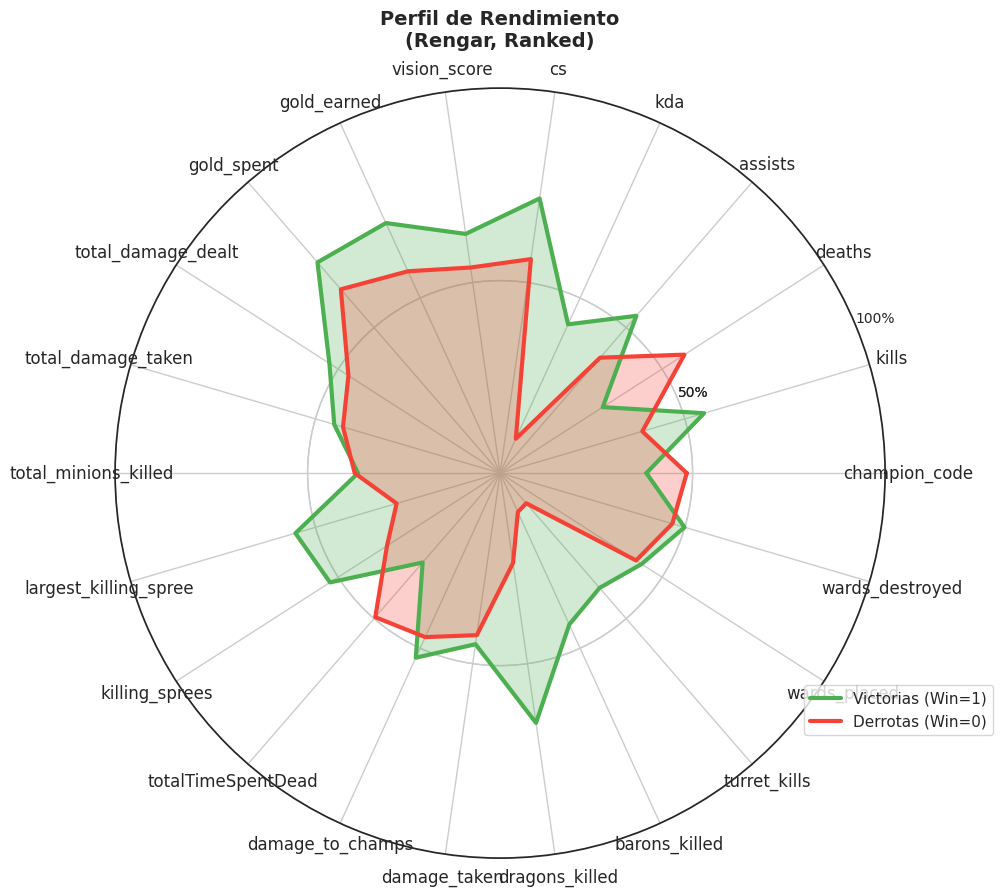

In [ ]:
variables_radar = ['champion_code', 'kills', 'deaths',
       'assists', 'kda', 'cs', 'vision_score', 'gold_earned', 'gold_spent',
       'total_damage_dealt', 'total_damage_taken', 'total_minions_killed', 'largest_killing_spree',
       'killing_sprees', 'totalTimeSpentDead','damage_to_champs', 'damage_taken',
       'dragons_killed', 'barons_killed', 'turret_kills', 'wards_placed',
       'wards_destroyed']

# Percentiles
def normalize_by_percentile(series):
    p95 = np.percentile(series, 95)
    p5 = np.percentile(series, 5)
    return (series - p5) / (p95 - p5)

norm_data = df_ranked[variables_radar + ['win']].copy()
for var in variables_radar:
    norm_data[var] = normalize_by_percentile(norm_data[var])


mean_win1 = norm_data[norm_data['win']==1][variables_radar].mean()
mean_win0 = norm_data[norm_data['win']==0][variables_radar].mean()


categories = variables_radar
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)

# Win=1
values = mean_win1.tolist()
values += values[:1]
ax.plot(angles, values, color='#4CAF50', linewidth=3, label='Victorias (Win=1)')
ax.fill(angles, values, color='#4CAF50', alpha=0.25)

# Win=0
values = mean_win0.tolist()
values += values[:1]
ax.plot(angles, values, color='#F44336', linewidth=3, label='Derrotas (Win=0)')
ax.fill(angles, values, color='#F44336', alpha=0.25)

plt.xticks(angles[:-1], categories, fontsize=12)
plt.yticks([0.5, 0.5, 1], ['0%', '50%', '100%'], fontsize=10)
plt.ylim(0, 1)

# Título y leyenda
plt.title('Perfil de Rendimiento\n(Rengar, Ranked)',
          pad=30, fontsize=14, fontweight='bold')
plt.legend(loc='lower right', bbox_to_anchor=(1.15, 0.15))


plt.show()

In [ ]:
df_ranked.columns

Index(['date', 'region', 'game_id', 'champion', 'win', 'kills', 'deaths',
       'assists', 'kda', 'cs', 'vision_score', 'gold_earned', 'gold_spent',
       'total_damage_dealt', 'total_damage_taken', 'magic_damage_dealt',
       'physical_damage_dealt', 'true_damage_dealt', 'timeCCingOthers',
       'total_minions_killed', 'largest_killing_spree', 'largest_multi_kill',
       'killing_sprees', 'perks', 'longest_time_spent_living',
       'total_units_healed', 'totalTimeSpentDead',
       'vision_wards_bought_in_game', 'game_duration', 'queue_id',
       'team_position', 'lane', 'role', 'level', 'game_version', 'map_id',
       'game_name', 'game_creation', 'game_type', 'platform_id',
       'participants', 'summoner_spells', 'damage_to_champs', 'damage_taken',
       'dragons_killed', 'barons_killed', 'turret_kills', 'wards_placed',
       'wards_destroyed', 'item_1', 'champion_code'],
      dtype='object')

In [ ]:
conteo_campeones = df_ranked['champion'].value_counts().reset_index()
conteo_campeones.columns = ['champion', 'games_played']

# Mostrar la tabla
print(conteo_campeones)

        champion  games_played
0        DrMundo            33
1             Vi            10
2       Volibear             9
3        Warwick             9
4       MasterYi             9
5        Kindred             5
6        Sejuani             3
7          Amumu             2
8       JarvanIV             2
9   FiddleSticks             1
10           Zac             1
11        Lucian             1
12      Vladimir             1
13        Khazix             1
14      Nocturne             1
15    MonkeyKing             1
16       XinZhao             1
17          Kayn             1


In [ ]:
df_ranked.groupby('team_position')['win'].mean().sort_values(ascending=False)



,win
team_position,
JUNGLE,0.423529
TOP,0.250000
BOTTOM,0.000000
MIDDLE,0.000000


In [ ]:
df_ranked['cs_threshold'] = df_ranked['total_minions_killed'] > 150
df_ranked.groupby('cs_threshold')['win'].mean()


,win
cs_threshold,
False,0.413793
True,0.250000


In [ ]:
# Calcula número de partidas y winrate por campeón
campeones = df_ranked.groupby('champion').agg(
    partidas=('win', 'count'),
    winrate=('win', 'mean')
).reset_index()

# Ordena por más jugados
campeones = campeones.sort_values('partidas', ascending=False)

# Opcional: Solo los top N campeones, agrupa el resto como "Otros"
N = 8
otros = campeones.iloc[N:].copy()
otros_partidas = otros['partidas'].sum()
otros_winrate = (otros['partidas'] * otros['winrate']).sum() / otros_partidas if otros_partidas > 0 else 0

# Top campeones + "Otros"
campeones_top = campeones.iloc[:N].copy()
campeones_top = campeones_top.append(
    pd.DataFrame([{'champion': 'Otros', 'partidas': otros_partidas, 'winrate': otros_winrate}]),
    ignore_index=True
)

# Etiquetas: nombre + winrate en %
campeones_top['label'] = campeones_top.apply(
    lambda row: f"{row['champion']} ({row['winrate']*100:.1f}%)", axis=1
)

# Pie chart
plt.figure(figsize=(8,8))
colors = plt.cm.Set3.colors  # paleta
plt.pie(
    campeones_top['partidas'],
    labels=campeones_top['label'],
    autopct=lambda pct: f"{pct:.1f}%",
    startangle=140,
    colors=colors
)
plt.title('Campeones más jugados y winrate (%)')
plt.tight_layout()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
df.columns

In [ ]:
# Filtrar solo partidas de Dr. Mundo
mundo_games = df[df['champion'] == 'DrMundo']

# Stats en victorias
win_stats = mundo_games[mundo_games['win'] == 1][['kills', 'deaths', 'assists', 'gold_earned', 'vision_score']].mean()

# Stats en derrotas
lose_stats = mundo_games[mundo_games['win'] == 0][['kills', 'deaths', 'assists', 'gold_earned', 'vision_score']].mean()

# Crear tabla comparativa
comparacion = pd.DataFrame({'Victorias': win_stats, 'Derrotas': lose_stats})
comparacion['Diferencia'] = comparacion['Victorias'] - comparacion['Derrotas']
print(comparacion)

#Analisis 2


In [ ]:
# Verificar datos nulos
df_ranked.isnull().sum()

# Eliminar o imputar valores nulos según sea necesario
df_ranked = df_ranked.dropna()  # Si decides eliminar las filas con valores nulos

# Asegurarse de que las variables numéricas estén en el formato correcto
df_ranked['gold_earned'] = pd.to_numeric(df_ranked['gold_earned'], errors='coerce')
df_ranked['damage_to_champs'] = pd.to_numeric(df_ranked['damage_to_champs'], errors='coerce')
df_ranked['dragons_killed'] = pd.to_numeric(df_ranked['dragons_killed'], errors='coerce')
# Puedes hacer esto con otras variables numéricas


In [ ]:
# Seleccionar solo las variables más importantes
important_vars = ['gold_earned', 'damage_to_champs', 'kda', 'dragons_killed', 'barons_killed', 'turret_kills', 'win']

# Filtrar el dataframe
df_important = df[important_vars]

# Calcular la matriz de correlación
corr_matrix = df_important.corr()

# Mostrar la correlación con la columna 'win'
win_corr = corr_matrix['win'].sort_values(ascending=False)
print(win_corr)

# Matriz de correlación visualmente estilizada (solo para las variables importantes)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Reds', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlación (Variables Importantes)", fontsize=16)
plt.show()


In [ ]:
# Gráfico de dispersión entre oro ganado y victoria
plt.figure(figsize=(10, 6))
sns.scatterplot(x='gold_earned', y='win', data=df_important, color='#ff69b4', s=100, edgecolor='black')
plt.title('Oro Ganado vs. Victoria', fontsize=16)
plt.xlabel('Oro Ganado', fontsize=14)
plt.ylabel('Victoria (1 = Gana, 0 = Pierde)', fontsize=14)
plt.grid(True)
plt.show()

# Gráfico de dispersión entre daño a campeones y victoria
plt.figure(figsize=(10, 6))
sns.scatterplot(x='damage_to_champs', y='win', data=df_important, color='#ff69b4', s=100, edgecolor='black')
plt.title('Daño a Campeones vs. Victoria', fontsize=16)
plt.xlabel('Daño a Campeones', fontsize=14)
plt.ylabel('Victoria (1 = Gana, 0 = Pierde)', fontsize=14)
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Supongo que ya tienes tu DataFrame df con las variables relevantes
# Asegúrate de que 'win' sea la variable objetivo (0 = derrota, 1 = victoria)

# Seleccionamos las variables relevantes para el modelo
features = ['gold_earned', 'damage_to_champs', 'kda', 'dragons_killed', 'barons_killed', 'turret_kills']
target = 'win'

# X = características (variables predictoras)
# y = variable objetivo (resultado de la partida)
X = df[features]
y = df[target]

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar los primeros datos para asegurar que está todo bien
print(X_train.head())


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Creamos el modelo de árbol de decisión
model = DecisionTreeClassifier(random_state=42)

# Entrenamos el modelo
model.fit(X_train, y_train)

# Realizamos predicciones
y_pred = model.predict(X_test)

# Evaluamos el rendimiento del modelo
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de Confusión
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))


In [ ]:
# Obtener la importancia de las características
importancia = model.feature_importances_

# Mostrar la importancia de las características
for feature, importance in zip(features, importancia):
    print(f"{feature}: {importance:.4f}")


In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Graficar el árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=features, class_names=['Perdida', 'Victoria'], filled=True, rounded=True, fontsize=14)
plt.title("Árbol de Decisión - Predicción de Victoria/Derrota")
plt.show()


In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Suponiendo que el modelo ya está entrenado
# Limitar la profundidad del árbol para que sea más fácil de visualizar
model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Graficar el árbol con parámetros ajustados
plt.figure(figsize=(15, 10))
plot_tree(model,
          feature_names=features,  # Nombres de las características
          class_names=["Perdida", "Victoria"],  # Nombres de las clases
          filled=True,  # Colorear los nodos según la clase
          rounded=True,  # Bordes redondeados para mayor claridad
          fontsize=12)  # Tamaño de la fuente
plt.title("Árbol de Decisión - Predicción de Victoria/Derrota", fontsize=16)
plt.show()


#Arbold de descison 2parte

In [ ]:
!apt-get install -y graphviz
!pip install graphviz


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Entrenar modelo con más profundidad
modelo_pro = DecisionTreeClassifier(max_depth=4, random_state=42)
modelo_pro.fit(X_train, y_train)


In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Exportar el árbol como código DOT
dot_data = export_graphviz(modelo_pro,
                           out_file=None,
                           feature_names=features,
                           class_names=["Perdida", "Victoria"],
                           filled=True,
                           rounded=True,
                           special_characters=True)

# Crear visualización
grafico = graphviz.Source(dot_data)
grafico.render("arbol_decision_pro", format="png", cleanup=False)  # Guarda el PNG
grafico  # Muestra en notebook


#Arbol 2

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

# Entrenar el modelo con más profundidad
modelo_pro = DecisionTreeClassifier(max_depth=5, random_state=42)
modelo_pro.fit(X_train, y_train)

# Evaluar el rendimiento
from sklearn.metrics import classification_report
y_pred = modelo_pro.predict(X_test)
print(classification_report(y_test, y_pred))


In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Exportar el árbol como código DOT
dot_data = export_graphviz(modelo_pro,
                           out_file=None,
                           feature_names=features,
                           class_names=["Perdida", "Victoria"],
                           filled=True,
                           rounded=True,
                           special_characters=True)

# Crear visualización
grafico = graphviz.Source(dot_data)
grafico.render("arbol_decision_pro", format="png", cleanup=False)  # Guarda el PNG
grafico  # Muestra en notebook


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluación
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluación
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

In [ ]:
!pip install -U scikit-learn==1.2.2
!pip install dtreeviz --upgrade


In [ ]:
from dtreeviz import dtreeviz


# Entrena tu árbol
modelo_pro = DecisionTreeClassifier(max_depth=5, random_state=42)
modelo_pro.fit(X_train, y_train)

# Visualiza con dtreeviz
viz = dtreeviz(
    modelo_pro,
    X_train,
    y_train,
    target_name="win",
    feature_names=features,
    class_names=["Perdida", "Victoria"],  # Asegúrate que 'Victoria' es la clase positiva
    fancy=True,
    scale=1.2,
    colors = {
        0: "#e74c3c",   # Rojo para "Perdida"
        1: "#27ae60"    # Verde para "Victoria"
    }
)

viz.view()  # Esto lo abre en una pestaña nueva y lo puedes ver o guardar como imagen PNG.


In [ ]:
!pip install numpy==1.23.5
!pip install scikit-learn==1.2.2
!pip install dtreeviz==2.2.1


In [ ]:
from dtreeviz import dtreeviz


In [ ]:
#Entrena tu árbol
modelo_pro = DecisionTreeClassifier(max_depth=5, random_state=42)
modelo_pro.fit(X_train, y_train)


viz = dtreeviz(
    modelo_pro,
    X_train,
    y_train,
    target_name="win",
    feature_names=features,
    class_names=["Perdida", "Victoria"],
    fancy=True,
    scale=1.2,
    colors = {0: "#e74c3c", 1: "#27ae60"}
)
viz.view()


In [ ]:
from dtreeviz import model


modelo_pro = DecisionTreeClassifier(max_depth=5, random_state=42)
modelo_pro.fit(X_train, y_train)

# Crea el modelo visual
viz = model(
    modelo_pro,
    X_train,
    y_train,
    feature_names=features,
    target_name="Victoria",
    class_names=["Perdida", "Victoria"],
    colors={"Perdida": "#e74c3c", "Victoria": "#27ae60"},  # Nombres como string!
    fancy=True,
    scale=1.2,
)
viz.view()


#Arbol 3

In [ ]:
import plotly.express as px
import pandas as pd

# Crear un DataFrame con la importancia de las características
importancia = modelo_pro.feature_importances_
df_importancia = pd.DataFrame({
    'Característica': features,
    'Importancia': importancia
})

# Gráfico interactivo con plotly
fig = px.bar(df_importancia, x='Característica', y='Importancia', title="Importancia de las Características")
fig.show()


In [ ]:
import seaborn as sns

# Crear un gráfico de dispersión para ver la relación entre oro ganado y victoria
plt.figure(figsize=(10, 6))
sns.scatterplot(x='gold_earned', y='win', data=df)
plt.title("Relación entre Oro Ganado y Victoria")
plt.xlabel("Oro Ganado")
plt.ylabel("Victoria (1 = Gana, 0 = Pierde)")
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression

# Entrenar el modelo
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predicciones
y_pred_logreg = logreg.predict(X_test)

# Evaluar rendimiento
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_logreg))


In [ ]:
# Esto selecciona solo las columnas numéricas
corr = df.select_dtypes(include='number').corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr[['win']].sort_values(by='win', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlación de variables numéricas con Victoria')
plt.show()



In [ ]:
varcorrelacion = [
    'dragons_killed',
    'kda',
    'turret_kills',
    'largest_killing_spree',
    'barons_killed',
    'cs',
    'gold_earned',
    'kills',
    'assists',
    'deaths'
]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo: {acc:.2f}")

cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(cm)


In [ ]:
importances = clf.feature_importances_
plt.barh(features, importances)
plt.title("Importancia de las variables en el modelo")
plt.show()


In [ ]:
X = df_ranked[features]
y = df_ranked['win']

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Divide datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrena árbol
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Visualiza árbol
plt.figure(figsize=(18,8))
plot_tree(clf, feature_names=features, class_names=['Derrota', 'Victoria'], filled=True, rounded=True)
plt.show()


#Arbol final